Student: Alex Periti 

Email: alex.periti@studio.unibo.it

# Generating Images with Generative Adversarial Networks (GANs)

The purpose of the project is to test the ability of Generative Adversial Networks (GANs) in generating realistic-looking images. 

## Dataset

The dataset used will be FashionMNIST. It contains low resolution ($28 \times 28$) grey-scale images representing different kind of clothes. The dataset is available on keras and accessable in $\texttt{tf.keras.datasets.fashion\_mnist}$. Note that the pixel values for the images are initially in the interval $[0, 255]$. It is required to normalize them since all of the algorithm we will use require them to be in that format. To be fair, you will find the dataset already normalized, do not modify that part of the code.

## Metrics

Measuring the quality of newly generated images is a non-trivial task. Indeed, there is no label associated to each image, and thus it is impossible to measure the quality image-by-image. For that reason, common metrics uses statistical consideration on a generated dataset to test how well the network recovered the statistics of the original data. One of the most common is the Fréchet Inception Distance (FID). The idea of FID is that in a realistic-looking dataset of images, the statistics of the activation of the last hidden layer in a well-trained classificator should be similar to that of a dataset containing real images. Specifically, regarding FID, the Inception-v3 network is used as a classificator. A real dataset $\mathbb{D}_r$ and a generated dataset $\mathbb{D}_g$ are processed by the network, and the activation of the last hidden layer has mean and variance $(\mu_r, \Sigma_r)$, $(\mu_g, \Sigma_g)$ respectively. Then, FID is computed as:

$$
    FID(\mathbb{D}_r, \mathbb{D}_g) = || \mu_r - \mu_g ||^2 + Tr(\Sigma_r + \Sigma_g - 2(\Sigma_r \ast \Sigma_g)^{\frac{1}{2}}) 
$$

A Python implementation of FID can be found in the file $\texttt{fid.py}$ that you find attached on Virtuale. Its usage is very simple, just generate $10k$ fake images with your GAN, and with the command $\texttt{fid.get\_fid(x\_test, x\_gen)}$, where $\texttt{x\_test}$ is the test set, containing $10k$ real images, you get the value for the FID of your network. Remember that, when passed through that function, $\texttt{x\_gen}$ **must** be a dataset of $10k$ images, in the interval $[0, 1]$. The number of $10k$ images is fundamental, since the value of FID strongly depends on the number of input images.

## Limitations

You are required to implement a vanilla Generative Adversarial Network (GAN), not a variant of it (e.g. PixelGAN, CycleGAN, ... are **not** accepted). The maximum number of parameters is *15 million*, and every pre-trained network can be used as an add-on (the number of parameters for pre-trained network does not count). Clearly, only the training set can be used to train the network, no additional images (Data Augmentation is ok).

In [ ]:
import tensorflow as tf
import keras.losses
from tensorflow.keras.layers import (Dense, 
                                     BatchNormalization, 
                                     LeakyReLU, 
                                     Reshape, 
                                     Conv2DTranspose,
                                     Conv2D,
                                     Dropout,
                                     Flatten,
                                     Input,
                                     ReLU,
                                     RandomContrast)

from tensorflow.keras.datasets import fashion_mnist
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from tensorflow.keras.utils import array_to_img
from tensorflow.keras.optimizers import schedules, Adam, RMSprop

import time
import numpy as np
from matplotlib import pyplot as plt


In order to save the checkpoint and model, give to Colab the accces to drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The images are normalized in $[0, 1]$. For simplicity, images are padded to have dimension $32 \times 32$.

In [ ]:
# Load the data. Note that the labels y_train and y_test are not loaded since not required.
(x_train, _), (x_test, _) = fashion_mnist.load_data()

# Normalize and pad the datasets
x_train = np.pad(x_train, ((0,0), (2,2), (2,2)))
x_train = np.reshape(x_train, x_train.shape + (1, ))
x_train = x_train / 255.

x_test = np.pad(x_test, ((0,0), (2,2), (2,2)))
x_test = np.reshape(x_test, x_test.shape + (1, ))
x_test = x_test / 255.

print(f"Training shape: {x_train.shape}, Training pixel values: {x_train.min(), x_train.max()}")
print(f"Test shape: {x_test.shape}, Test pixel values: {x_test.min(), x_test.max()}")

4431872/4422102 [==============================] - 0s 0us/step
Training shape: (60000, 32, 32, 1), Training pixel values: (0.0, 1.0)
Test shape: (10000, 32, 32, 1), Test pixel values: (0.0, 1.0)


In [ ]:
EPOCHS = 250 # trained for 350 epoch, but after 250 the FID score doesn't increase
BATCH_SIZE = 256
HALF_BATCH = 128
STEPS_PER_EPOCHS = int(x_train.shape[0]/BATCH_SIZE)
NOISE_DIM = 100
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

**Define the generator**

The generator  is responsible for generating 32x32 pixels grayscale fake images from random noise. Therefore, it needs to accept 1-dimensional arrays and output 32x32 pixels images. For this task, we need Transposed Convolution layers after reshaping the 1-dimensional array to a 2-dimensional array. Transposed Convolution layers can increase the size of a smaller array. We also take advantage of BatchNormalization and ReLU layers.

The batch normalization layers in both G and D help stabilize GAN training. Batchnorm standardizes the input layer to have a zero mean and unit variance. It’s typically added after the hidden layer and before the activation layer.

**The generator’s main tasks are:**



*   Convert the 1D random noise (latent vector) to 3D with the `Reshape` layer
*   Upsample a few times with Keras `Conv2DTranspose` layer, to the output image size, in this scenario, a grayscale image in the shape of 32x32x1.




There are a few layers forming building blocks for Generator:

*  `Dense` (fully connected) layer: only for reshaping and flatting the noise vector
*  `Conv2DTranspose`: upsampling
*  `BatchNormalization`: stabilize training; after the conv layer and before the activation function.
*   `ReLU` activation in Generator for all layers except for the output, which uses tanh.

In [ ]:
from keras.backend import binary_crossentropy

def make_generator_model():
  generator = Sequential(name = 'Generator')
  
  # prepare for reshape: FC => BN => RN layers
  generator.add(Dense(8 * 8 * 256, input_dim=NOISE_DIM))
  generator.add(BatchNormalization())
  generator.add(ReLU())

  # 1D => 3D: reshape the output of the previous layer 
  generator.add(Reshape((8, 8, 256)))

  # upsample to 16x16: apply a transposed CONV => BN => RELU
  generator.add(Conv2DTranspose(128, (5, 5), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
  generator.add(BatchNormalization())
  generator.add((ReLU()))

  # upsample to 32x32: apply a transposed CONV => BN => RELU
  generator.add(Conv2DTranspose(64, (5, 5), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
  generator.add(BatchNormalization())
  generator.add((ReLU()))

  # final layer: Conv2D with tanh activation
  generator.add(Conv2D(1, (5, 5), padding="same", activation="tanh")) #24 con tanh

  # return the generator model
  return generator

In [ ]:
generator = make_generator_model()
generator.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1654784   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      819328    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 128)      51

generate a sample image with the generator created above

In [ ]:
# Create a random noise and generate a sample
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
# Visualize the generated sample
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

**Define discriminator**

Discriminator is build up by following the inverse version of our generator network. It takes the 32x32 pixels image data and outputs a single value, representing the possibility of authenticity (real or fake). 

There are a couple of differences between a discriminator and a regular classifier, though:

*  We use `LeakyReLU` as the activation function (as suggested in some papers).
*  The discriminator has **two groups of input images**: the training dataset or real images labeled as 1, and the fake images created by the generator, labeled as 0.

(The discriminator network is typically smaller or simpler than the generator since the discriminator has a much easier job)

In [ ]:
def make_discriminator_model():
  
  discriminator = Sequential(name = 'Discriminator')
  # add a contrast layer as input with real images to highlight the features
  discriminator.add(RandomContrast(factor = (0.9), input_shape = (32,32,1)))

  # first set of CONV => BN => leaky ReLU layers
  # downsampling the input from (32,32,1) -> (16,16,64)
  discriminator.add(Conv2D(64, kernel_size = (5,5), strides = (2,2), padding = 'same', input_shape = (32,32,1)))
  discriminator.add(BatchNormalization())
  discriminator.add(LeakyReLU(0.3)) # 0.3 defining how much slope the leak is.

  # second set of CONV => BN => leacy ReLU layers
  # downsampling the input from (16,16,64) -> (8,8,128)
  discriminator.add(Conv2D(128, kernel_size = (5,5), strides = (2,2), padding = 'same'))
  discriminator.add(BatchNormalization())
  discriminator.add(LeakyReLU(0.3))

  # flatten and apply dropout
  # downsampling the input from (8,8,128) -> (8192)
  discriminator.add(Flatten())
  discriminator.add(Dropout(0.3))

  # sigmoid it's suited for binary classification, like in this case we have "real" or "fake"
  discriminator.add(Dense(1, activation = "sigmoid"))

  return discriminator

In [ ]:
discriminator = make_discriminator_model()
discriminator.build()
discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_contrast (RandomCont  (None, 32, 32, 1)        0         
 rast)                                                           
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        1664      
                                                                 
 batch_normalization_3 (Batc  (None, 16, 16, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 batch_normalization_4 (Batc  (None, 8, 8, 128)      

**Configure the Model**

Since we are training two sub-networks inside a GAN network, we need to define two loss functions and two optimizers

*   As **optimizers** we can use Adam (tested also RMSprop and Adagrad but the resulst were worse)
*   The **discriminator loss** includes both the loss from the real images and the loss from the fake images. The **generator loss** is calculated with the fake images.



In [ ]:
# Training shape: (60000, 32, 32, 1)
# Remainder:
#   - 60000 is the batch_size
#   - 32x32 is the size of the img
#   - 1 is the channel

In [ ]:
gan_optimizer = Adam(
    learning_rate = 2e-4,
    beta_1 = 0.5
)

In [ ]:
class DCGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    # Train loop
    def train_step(self, real_images):

        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # -------------------------------------------------------------
        # Step 1. Train the discriminator with both real images (label as 1) and fake images (classified as label as 0) 
        with tf.GradientTape() as tape:
            # Compute discriminator loss on real images
            pred_real = self.discriminator(real_images, training=True)
            d_loss_real = self.loss_fn(tf.ones((batch_size, 1)), pred_real)

            # Compute discriminator loss on fake images
            fake_images = self.generator(noise)
            pred_fake = self.discriminator(fake_images, training=True)
            d_loss_fake = self.loss_fn(tf.zeros((batch_size, 1)), pred_fake)

            # total discriminator loss
            d_loss = (d_loss_real + d_loss_fake)/2
        # Compute discriminator gradients
        grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        # Update discriminator weights
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))

        # -------------------------------------------------------------
        # Step 2. Train the generator (do not update weights of the discriminator)
        # G wants D to think the fake images are real (label as 1)
        misleading_labels = tf.ones((batch_size, 1)) 

        with tf.GradientTape() as tape:
            fake_images = self.generator(noise, training=True)
            pred_fake = self.discriminator(fake_images, training=True)
            g_loss = self.loss_fn(misleading_labels, pred_fake)
        # Compute generator gradients
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update generator weights
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

**Monitoring the perfomance of GAN**

Since the `train_step` of keras.Model has been overrided, now it's possible to create a subclass Callback to monitor our DCGAN training.

This `GANMonitor Callback()` is used to monitor:

*  Discriminator loss
*  Generator loss
*  Images that get generated during training

For GANs, Discriminator losses and Generator losses indicate how each model is performing individually.

I use the seed noise to create images (with the generator model) throughout the training to visually inspect the progress of the generator. At the end of the training i save the generator model.

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim

        # Create random noise seed for visualization during training
        self.seed = tf.random.normal([16, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        # random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        # generated_images = self.model.generator(random_latent_vectors)
        generated_images = self.model.generator(self.seed)
        generated_images = (generated_images * 127.5) + 127.5
        generated_images.numpy()

        # create a plot to visually check the performance
        fig = plt.figure(figsize=(4, 4))
        for i in range(self.num_img):
            plt.subplot(4, 4, i+1)
            img = array_to_img(generated_images[i]) 
            plt.imshow(img, cmap='gray')
            plt.axis('off')
        plt.savefig('epoch_{:03d}.png'.format(epoch)) 
        plt.show()

    def on_train_end(self, logs=None):
        self.model.generator.save('generator.h5')

**Train the DCGAN model**

Compile the dcgan model, with the Adam optimizer, learning rate of 0.0002, and the Binary Cross Entropy loss function (recommended in paper https://arxiv.org/abs/1511.06434).


In [ ]:
dcgan = DCGAN(discriminator=discriminator, generator=generator, latent_dim=NOISE_DIM)

In [ ]:
LR = 0.0002 # learning rate

dcgan.compile(
    d_optimizer=gan_optimizer,
    g_optimizer=gan_optimizer,
    loss_fn=keras.losses.BinaryCrossentropy(),
)

# used to return a generic grad for RandomContrast layer
@tf.RegisterGradient("AdjustContrastv2")
def _AdjustContrastv2(op,grad):
  return grad, tf.negative(grad)

Epoch 1/100
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6763 - g_loss: 0.7752

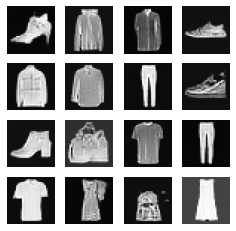

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6763 - g_loss: 0.7752
Epoch 2/100
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6734 - g_loss: 0.7700

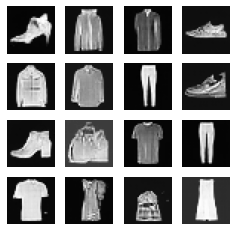

1875/1875 [==============================] - 38s 20ms/step - d_loss: 0.6734 - g_loss: 0.7699
Epoch 3/100
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6755 - g_loss: 0.7711

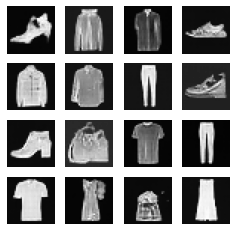

1875/1875 [==============================] - 38s 21ms/step - d_loss: 0.6755 - g_loss: 0.7711
Epoch 4/100
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6760 - g_loss: 0.7687

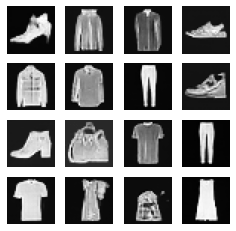

1875/1875 [==============================] - 39s 21ms/step - d_loss: 0.6760 - g_loss: 0.7687
Epoch 5/100
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6747 - g_loss: 0.7753

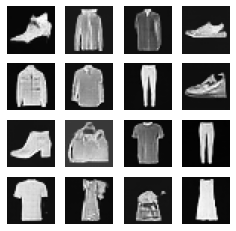

1875/1875 [==============================] - 39s 21ms/step - d_loss: 0.6745 - g_loss: 0.7754
Epoch 6/100
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6766 - g_loss: 0.7762

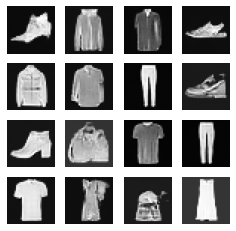

1875/1875 [==============================] - 39s 21ms/step - d_loss: 0.6766 - g_loss: 0.7763
Epoch 7/100
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6762 - g_loss: 0.7651

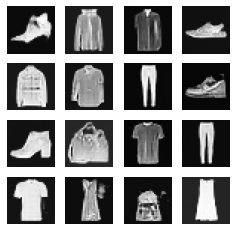

1875/1875 [==============================] - 39s 21ms/step - d_loss: 0.6762 - g_loss: 0.7650
Epoch 8/100
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6775 - g_loss: 0.7700

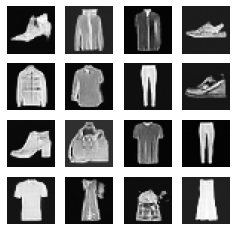

1875/1875 [==============================] - 39s 21ms/step - d_loss: 0.6775 - g_loss: 0.7700
Epoch 9/100
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6770 - g_loss: 0.7719

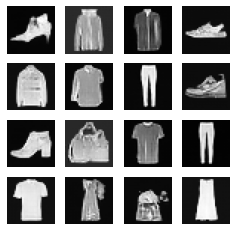

1875/1875 [==============================] - 39s 21ms/step - d_loss: 0.6771 - g_loss: 0.7719
Epoch 10/100
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6762 - g_loss: 0.7704

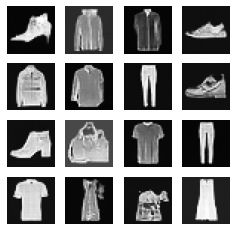

1875/1875 [==============================] - 39s 21ms/step - d_loss: 0.6761 - g_loss: 0.7705
Epoch 11/100
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6753 - g_loss: 0.7719

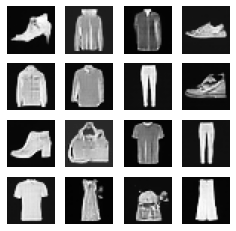

1875/1875 [==============================] - 39s 21ms/step - d_loss: 0.6753 - g_loss: 0.7719
Epoch 12/100
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6753 - g_loss: 0.7732

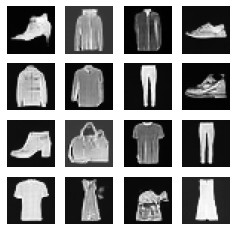

1875/1875 [==============================] - 39s 21ms/step - d_loss: 0.6753 - g_loss: 0.7731
Epoch 13/100
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6756 - g_loss: 0.7724

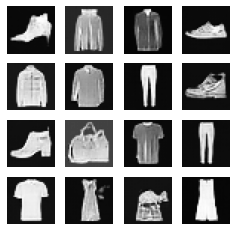

1875/1875 [==============================] - 40s 21ms/step - d_loss: 0.6756 - g_loss: 0.7724
Epoch 14/100
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6777 - g_loss: 0.7732

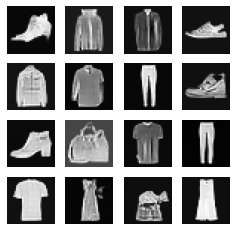

1875/1875 [==============================] - 40s 21ms/step - d_loss: 0.6777 - g_loss: 0.7732
Epoch 15/100
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6756 - g_loss: 0.7713

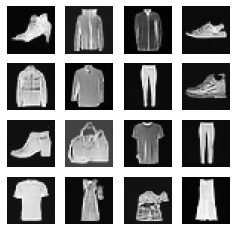

1875/1875 [==============================] - 40s 21ms/step - d_loss: 0.6756 - g_loss: 0.7713
Epoch 16/100
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6757 - g_loss: 0.7748

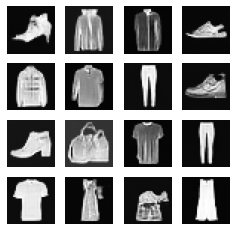

1875/1875 [==============================] - 40s 21ms/step - d_loss: 0.6757 - g_loss: 0.7748
Epoch 17/100
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6758 - g_loss: 0.7672

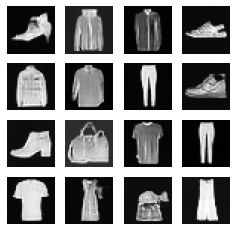

1875/1875 [==============================] - 40s 21ms/step - d_loss: 0.6759 - g_loss: 0.7671
Epoch 18/100
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6776 - g_loss: 0.7706

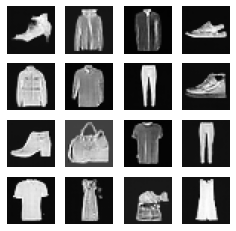

1875/1875 [==============================] - 40s 21ms/step - d_loss: 0.6776 - g_loss: 0.7706
Epoch 19/100
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6743 - g_loss: 0.7725

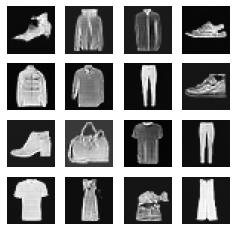

1875/1875 [==============================] - 40s 21ms/step - d_loss: 0.6743 - g_loss: 0.7724
Epoch 20/100
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6754 - g_loss: 0.7754

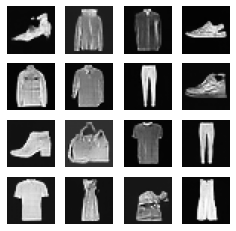

1875/1875 [==============================] - 40s 21ms/step - d_loss: 0.6754 - g_loss: 0.7753
Epoch 21/100
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6766 - g_loss: 0.7666

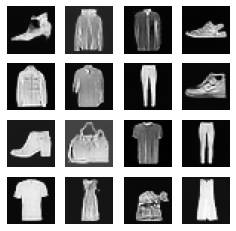

1875/1875 [==============================] - 40s 21ms/step - d_loss: 0.6767 - g_loss: 0.7666
Epoch 22/100
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6749 - g_loss: 0.7724

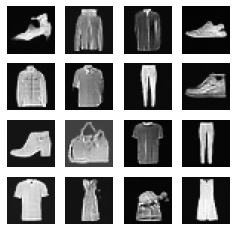

1875/1875 [==============================] - 40s 21ms/step - d_loss: 0.6748 - g_loss: 0.7724
Epoch 23/100
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6773 - g_loss: 0.7712

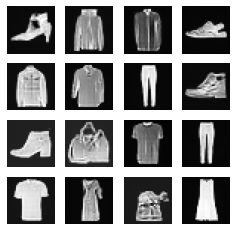

1875/1875 [==============================] - 40s 21ms/step - d_loss: 0.6773 - g_loss: 0.7712
Epoch 24/100
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6764 - g_loss: 0.7701

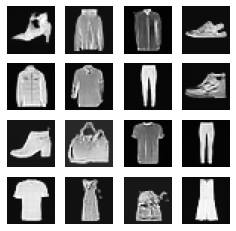

1875/1875 [==============================] - 40s 21ms/step - d_loss: 0.6764 - g_loss: 0.7703
Epoch 25/100
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6762 - g_loss: 0.7700

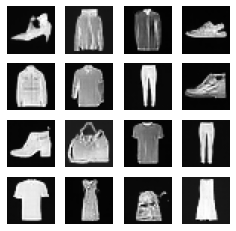

1875/1875 [==============================] - 40s 22ms/step - d_loss: 0.6763 - g_loss: 0.7702
Epoch 26/100
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6749 - g_loss: 0.7680

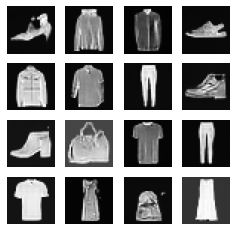

1875/1875 [==============================] - 40s 21ms/step - d_loss: 0.6749 - g_loss: 0.7680
Epoch 27/100
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6764 - g_loss: 0.7670

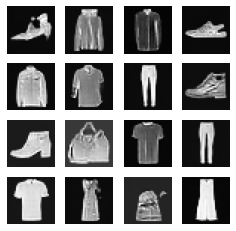

1875/1875 [==============================] - 40s 22ms/step - d_loss: 0.6764 - g_loss: 0.7670
Epoch 28/100
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6782 - g_loss: 0.7674

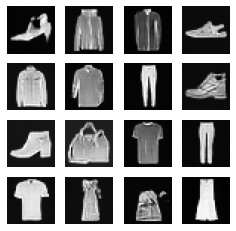

1875/1875 [==============================] - 40s 21ms/step - d_loss: 0.6781 - g_loss: 0.7674
Epoch 29/100
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6737 - g_loss: 0.7710

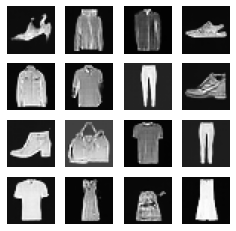

1875/1875 [==============================] - 40s 22ms/step - d_loss: 0.6737 - g_loss: 0.7709
Epoch 30/100
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6755 - g_loss: 0.7708

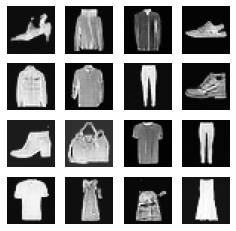

1875/1875 [==============================] - 40s 21ms/step - d_loss: 0.6755 - g_loss: 0.7708
Epoch 31/100
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6735 - g_loss: 0.7703

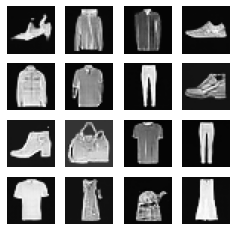

1875/1875 [==============================] - 40s 22ms/step - d_loss: 0.6735 - g_loss: 0.7704
Epoch 32/100
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6774 - g_loss: 0.7704

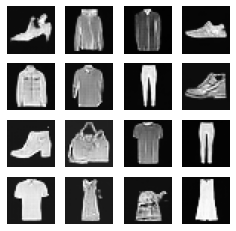

1875/1875 [==============================] - 40s 22ms/step - d_loss: 0.6774 - g_loss: 0.7704
Epoch 33/100
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6760 - g_loss: 0.7660

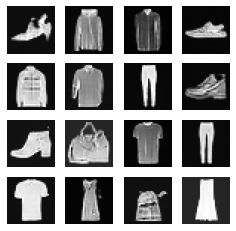

1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6760 - g_loss: 0.7660
Epoch 34/100
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6746 - g_loss: 0.7685

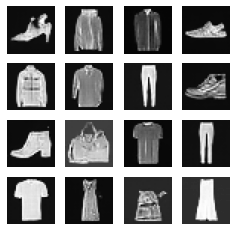

1875/1875 [==============================] - 40s 21ms/step - d_loss: 0.6746 - g_loss: 0.7685
Epoch 35/100
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6755 - g_loss: 0.7684

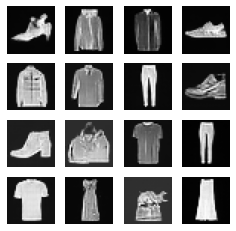

1875/1875 [==============================] - 40s 22ms/step - d_loss: 0.6755 - g_loss: 0.7684
Epoch 36/100
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6771 - g_loss: 0.7706

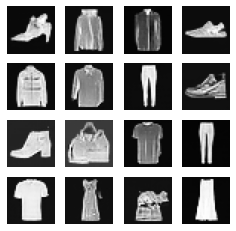

1875/1875 [==============================] - 40s 22ms/step - d_loss: 0.6771 - g_loss: 0.7707
Epoch 37/100
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6737 - g_loss: 0.7690

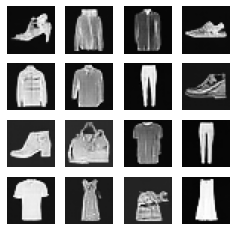

1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6737 - g_loss: 0.7690
Epoch 38/100
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6777 - g_loss: 0.7690

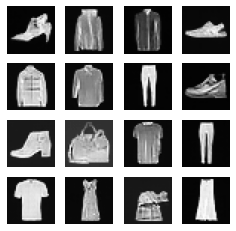

1875/1875 [==============================] - 40s 22ms/step - d_loss: 0.6778 - g_loss: 0.7690
Epoch 39/100
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6761 - g_loss: 0.7696

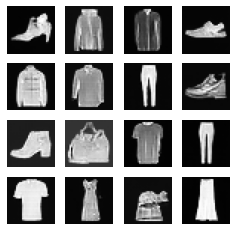

1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6761 - g_loss: 0.7696
Epoch 40/100
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6757 - g_loss: 0.7717

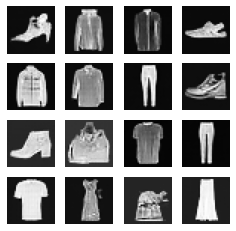

1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6757 - g_loss: 0.7717
Epoch 41/100
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6753 - g_loss: 0.7728

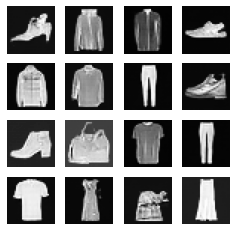

1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6753 - g_loss: 0.7728
Epoch 42/100
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6756 - g_loss: 0.7689

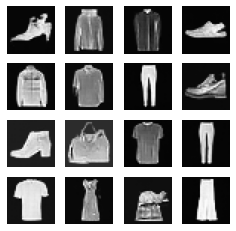

1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6756 - g_loss: 0.7688
Epoch 43/100
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6760 - g_loss: 0.7693

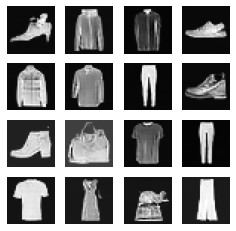

1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6760 - g_loss: 0.7693
Epoch 44/100
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6758 - g_loss: 0.7715

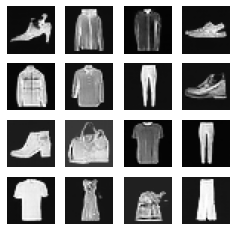

1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6759 - g_loss: 0.7715
Epoch 45/100
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6761 - g_loss: 0.7698

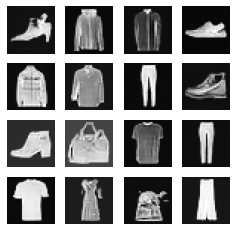

1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6761 - g_loss: 0.7700
Epoch 46/100
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6762 - g_loss: 0.7675

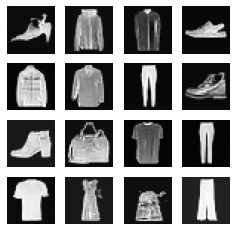

1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6763 - g_loss: 0.7675
Epoch 47/100
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6725 - g_loss: 0.7768

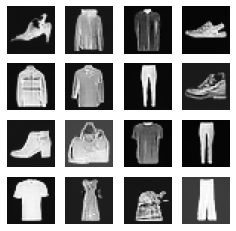

1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6725 - g_loss: 0.7768
Epoch 48/100
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6760 - g_loss: 0.7662

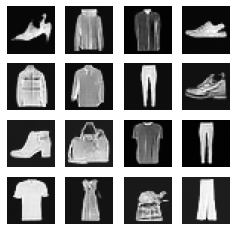

1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6760 - g_loss: 0.7661
Epoch 49/100
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6751 - g_loss: 0.7702

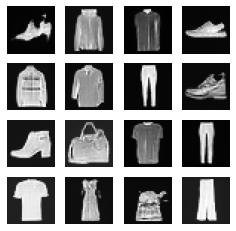

1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6751 - g_loss: 0.7702
Epoch 50/100
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6741 - g_loss: 0.7707

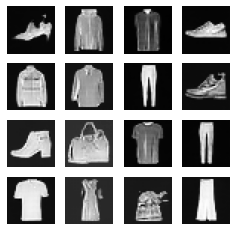

1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6741 - g_loss: 0.7707
Epoch 51/100
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6759 - g_loss: 0.7727

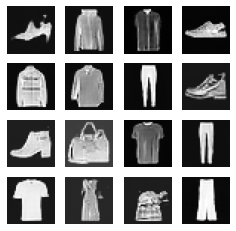

1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6759 - g_loss: 0.7727
Epoch 52/100
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6767 - g_loss: 0.7710

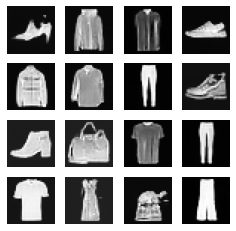

1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6767 - g_loss: 0.7710
Epoch 53/100
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6751 - g_loss: 0.7755

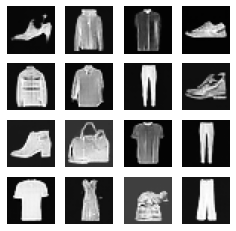

1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6751 - g_loss: 0.7756
Epoch 54/100
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6748 - g_loss: 0.7704

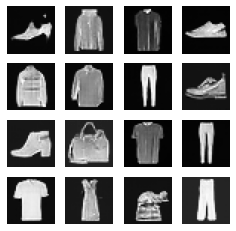

1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6748 - g_loss: 0.7704
Epoch 55/100
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6734 - g_loss: 0.7676

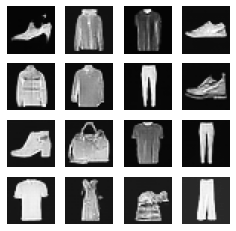

1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6734 - g_loss: 0.7676
Epoch 56/100
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6737 - g_loss: 0.7693

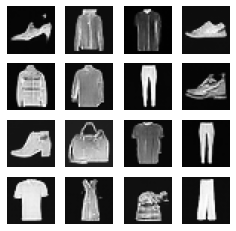

1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6737 - g_loss: 0.7693
Epoch 57/100
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6741 - g_loss: 0.7737

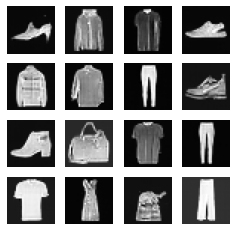

1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6741 - g_loss: 0.7737
Epoch 58/100
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6754 - g_loss: 0.7706

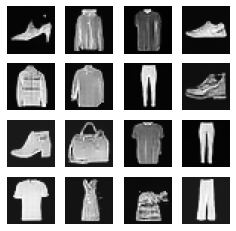

1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6754 - g_loss: 0.7706
Epoch 59/100
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6752 - g_loss: 0.7686

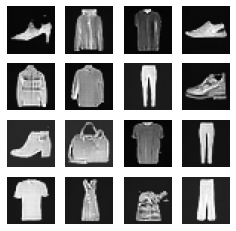

1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6753 - g_loss: 0.7687
Epoch 60/100
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6764 - g_loss: 0.7750

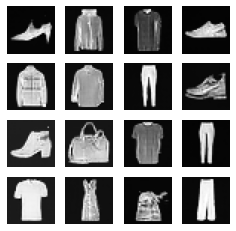

1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6764 - g_loss: 0.7750
Epoch 61/100
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6765 - g_loss: 0.7738

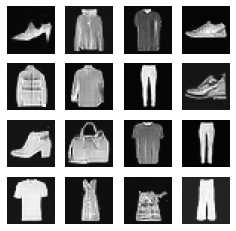

1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6765 - g_loss: 0.7738
Epoch 62/100
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6748 - g_loss: 0.7741

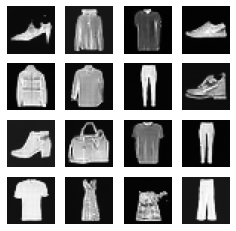

1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6748 - g_loss: 0.7741
Epoch 63/100
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6750 - g_loss: 0.7739

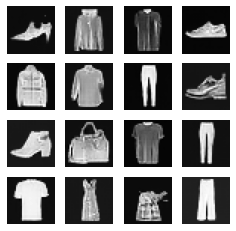

1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6750 - g_loss: 0.7739
Epoch 64/100
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6751 - g_loss: 0.7655

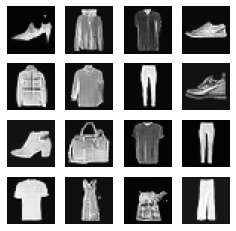

1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6751 - g_loss: 0.7655
Epoch 65/100
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6753 - g_loss: 0.7736

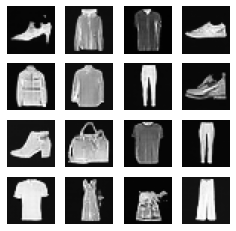

1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6753 - g_loss: 0.7737
Epoch 66/100
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6740 - g_loss: 0.7797

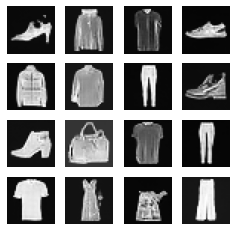

1875/1875 [==============================] - 43s 23ms/step - d_loss: 0.6740 - g_loss: 0.7797
Epoch 67/100
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6754 - g_loss: 0.7746

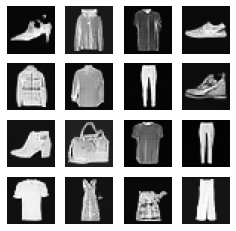

1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6754 - g_loss: 0.7746
Epoch 68/100
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6793 - g_loss: 0.7666

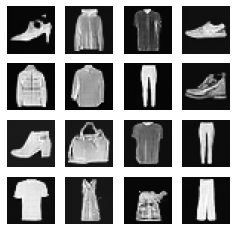

1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6793 - g_loss: 0.7666
Epoch 69/100
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6749 - g_loss: 0.7679

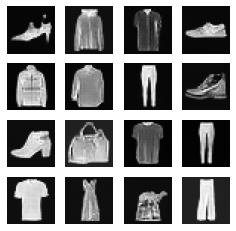

1875/1875 [==============================] - 42s 22ms/step - d_loss: 0.6749 - g_loss: 0.7679
Epoch 70/100
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6751 - g_loss: 0.7717

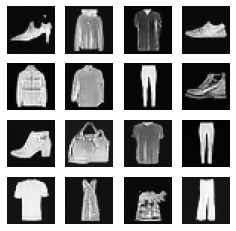

1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6751 - g_loss: 0.7717
Epoch 71/100
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6771 - g_loss: 0.7715

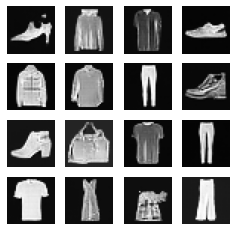

1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6771 - g_loss: 0.7715
Epoch 72/100
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6748 - g_loss: 0.7685

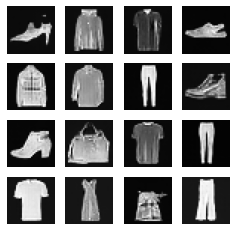

1875/1875 [==============================] - 43s 23ms/step - d_loss: 0.6748 - g_loss: 0.7685
Epoch 73/100
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6738 - g_loss: 0.7748

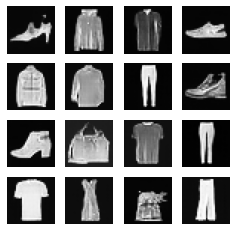

1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6738 - g_loss: 0.7747
Epoch 74/100
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6748 - g_loss: 0.7728

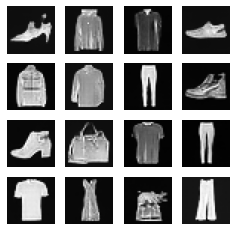

1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6748 - g_loss: 0.7728
Epoch 75/100
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6751 - g_loss: 0.7703

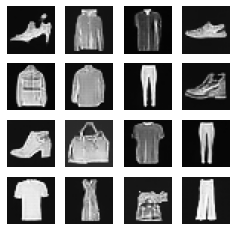

1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6749 - g_loss: 0.7705
Epoch 76/100
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6740 - g_loss: 0.7771

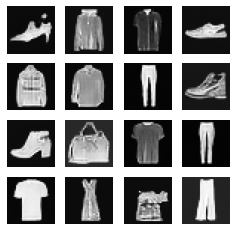

1875/1875 [==============================] - 42s 22ms/step - d_loss: 0.6740 - g_loss: 0.7771
Epoch 77/100
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6742 - g_loss: 0.7695

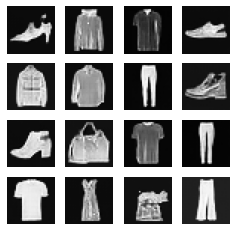

1875/1875 [==============================] - 42s 22ms/step - d_loss: 0.6743 - g_loss: 0.7695
Epoch 78/100
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6763 - g_loss: 0.7688

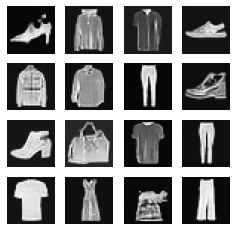

1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6763 - g_loss: 0.7688
Epoch 79/100
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6753 - g_loss: 0.7647

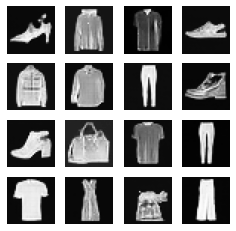

1875/1875 [==============================] - 44s 23ms/step - d_loss: 0.6753 - g_loss: 0.7647
Epoch 80/100
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6752 - g_loss: 0.7687

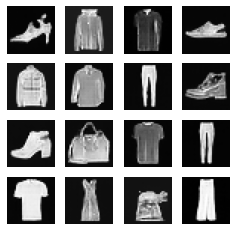

1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6752 - g_loss: 0.7687
Epoch 81/100
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6756 - g_loss: 0.7739

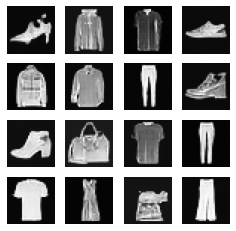

1875/1875 [==============================] - 42s 22ms/step - d_loss: 0.6756 - g_loss: 0.7739
Epoch 82/100
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6768 - g_loss: 0.7646

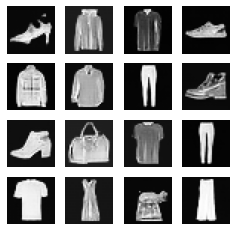

1875/1875 [==============================] - 42s 22ms/step - d_loss: 0.6768 - g_loss: 0.7646
Epoch 83/100
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6749 - g_loss: 0.7700

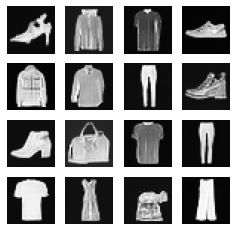

1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6749 - g_loss: 0.7700
Epoch 84/100
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6750 - g_loss: 0.7753

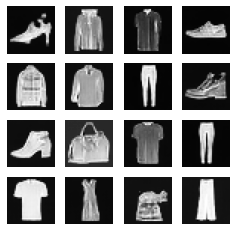

1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6750 - g_loss: 0.7753
Epoch 85/100
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6742 - g_loss: 0.7746

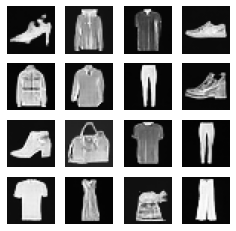

1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6742 - g_loss: 0.7746
Epoch 86/100
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6754 - g_loss: 0.7712

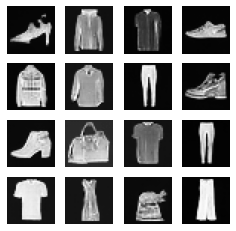

1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6755 - g_loss: 0.7711
Epoch 87/100
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6748 - g_loss: 0.7682

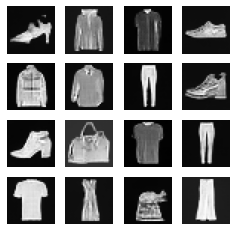

1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6748 - g_loss: 0.7682
Epoch 88/100
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6760 - g_loss: 0.7688

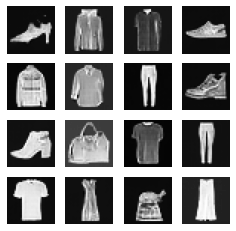

1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6760 - g_loss: 0.7688
Epoch 89/100
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6760 - g_loss: 0.7718

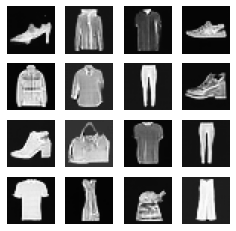

1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6760 - g_loss: 0.7718
Epoch 90/100
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6753 - g_loss: 0.7732

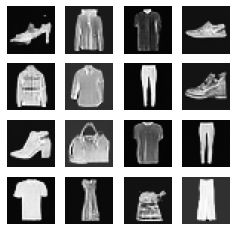

1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6753 - g_loss: 0.7732
Epoch 91/100
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6748 - g_loss: 0.7687

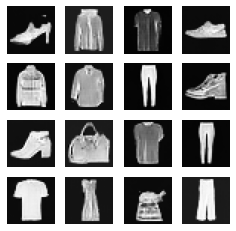

1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6748 - g_loss: 0.7688
Epoch 92/100
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6745 - g_loss: 0.7764

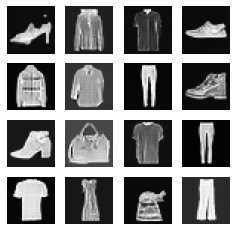

1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6745 - g_loss: 0.7765
Epoch 93/100
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6767 - g_loss: 0.7700

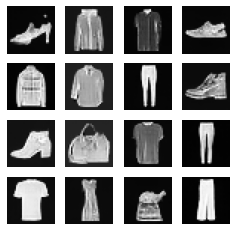

1875/1875 [==============================] - 42s 22ms/step - d_loss: 0.6767 - g_loss: 0.7700
Epoch 94/100
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6755 - g_loss: 0.7701

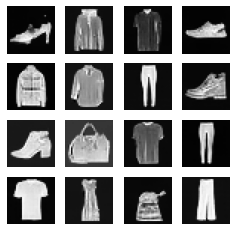

1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6755 - g_loss: 0.7701
Epoch 95/100
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6749 - g_loss: 0.7708

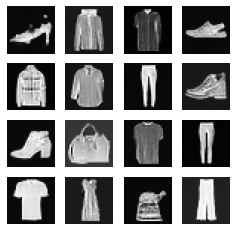

1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6749 - g_loss: 0.7708
Epoch 96/100
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6760 - g_loss: 0.7688

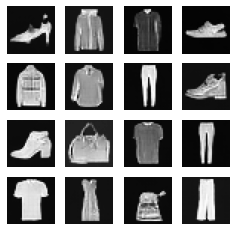

1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6759 - g_loss: 0.7688
Epoch 97/100
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6753 - g_loss: 0.7685

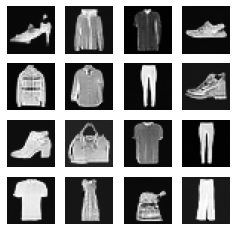

1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6753 - g_loss: 0.7685
Epoch 98/100
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6759 - g_loss: 0.7698

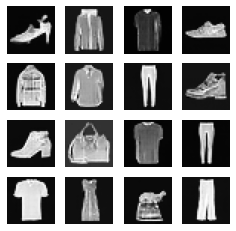

1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6759 - g_loss: 0.7700
Epoch 99/100
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6741 - g_loss: 0.7729

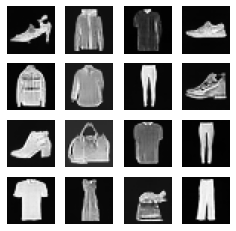

1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6741 - g_loss: 0.7729
Epoch 100/100
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6747 - g_loss: 0.7712

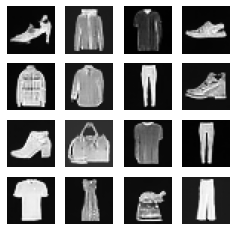

1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6746 - g_loss: 0.7713


In [ ]:
dcgan.fit(x_train, epochs=EPOCHS, callbacks=[GANMonitor(num_img=16, latent_dim=NOISE_DIM)])

**Use Generator to predict images**

Finally we can use the trained generator of the DCGAN to predict 10000 images and check if we reach a good FID score

In [ ]:
samples = 10000
noise = np.random.normal(0,1,size = (samples, NOISE_DIM))
predictions = generator.predict(noise)
print(predictions.shape)

(10000, 32, 32, 1)


In [ ]:
"""
Do not modify this code. This is just for utilities.
"""

import os
from tensorflow.keras.applications.inception_v3 import InceptionV3

# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3), weights='imagenet')

def get_inception_activations(inps, batch_size=100):
    """
    Compute the activation for the model Inception v3 for a given input 'inps'.

    Note: inps is assumed to be normalized in [0, 1].
    """
    n_batches = inps.shape[0] // batch_size

    act = np.zeros([inps.shape[0], 2048], dtype=np.float32)
    for i in range(n_batches):
        # Load a batch of data
        inp = inps[i * batch_size:(i + 1) * batch_size]

        # Resize each image to match the input shape of Inception v3
        inpr = tf.image.resize(inp, (299, 299))

        # Resize images in the interval [-1, 1], given that inpr is in [0, 1].
        inpr = inpr * 2 - 1 

        # Predict the activation
        act[i * batch_size:(i + 1) * batch_size] = model.predict(inpr, steps=1)

        print(f"Processed {str((i + 1) * batch_size)} images.")
    return act


def get_fid(images1, images2):
    """
    Compute the FID between two sets of images.

    Note: it can take several minutes.
    """
    from scipy.linalg import sqrtm

    shape = np.shape(images1)[1]
    print("Computing FID for {} dimensional images".format(images1.shape))

    # Inception v3 requires the input to have 3 channel. If this is not the
    # case, just copy the same channel three times.
    if images1.shape[-1] == 1:
        images1 = np.concatenate([images1, images1, images1], axis=-1)
        images2 = np.concatenate([images2, images2, images2], axis=-1)

    # activation for true images is always the same: we just compute it once
    if os.path.exists("act_mu.npy"):
        mu1 = np.load("act_mu.npy")
        sigma1 = np.load("act_sigma.npy")
    else:
        act1 = get_inception_activations(images1)
        mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
        np.save("act_mu.npy", mu1)
        np.save("act_sigma.npy", sigma1)
    print('Done stage 1 of 2')

    act2 = get_inception_activations(images2)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    print('Done stage 2 of 2')

    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2) ** 2.0)

    # compute sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

87924736/87910968 [==============================] - 0s 0us/step


In [ ]:
final_fid = get_fid(x_test, predictions)

# Print out the results
print(f"FID(x_test, predictions) = {final_fid}")

Computing FID for (10000, 32, 32, 1) dimensional images
Done stage 1 of 2
Processed 100 images.
Processed 200 images.
Processed 300 images.
Processed 400 images.
Processed 500 images.
Processed 600 images.
Processed 700 images.
Processed 800 images.
Processed 900 images.
Processed 1000 images.
Processed 1100 images.
Processed 1200 images.
Processed 1300 images.
Processed 1400 images.
Processed 1500 images.
Processed 1600 images.
Processed 1700 images.
Processed 1800 images.
Processed 1900 images.
Processed 2000 images.
Processed 2100 images.
Processed 2200 images.
Processed 2300 images.
Processed 2400 images.
Processed 2500 images.
Processed 2600 images.
Processed 2700 images.
Processed 2800 images.
Processed 2900 images.
Processed 3000 images.
Processed 3100 images.
Processed 3200 images.
Processed 3300 images.
Processed 3400 images.
Processed 3500 images.
Processed 3600 images.
Processed 3700 images.
Processed 3800 images.
Processed 3900 images.
Processed 4000 images.
Processed 4100 

In [ ]:
generator.save('/content/drive/MyDrive/Colab_Notebooks/Saved_Models/DCGANv2_final')
generator.save_weights('/content/drive/MyDrive/Colab_Notebooks/Saved_Weights/DCGANv2_final_weights')